
--- Running model: Regression ---
Regression RMSE: 1.0056

--- Running model: ARIMA ---


18:00:46 - cmdstanpy - INFO - Chain [1] start processing
18:00:46 - cmdstanpy - INFO - Chain [1] done processing


ARIMA RMSE: 2.6932

--- Running model: Prophet ---
Prophet RMSE: 2.2560

--- Running model: LSTM ---


18:01:01 - cmdstanpy - INFO - Chain [1] start processing


LSTM RMSE: 10.2169

--- Running model: XGBoost ---
XGBoost RMSE: 2.8052

--- Running model: Ensemble ---


18:01:01 - cmdstanpy - INFO - Chain [1] done processing


Ensemble RMSE: 1.0188

--- Running model: cluster_forecast ---
cluster_forecast RMSE: 1.0423


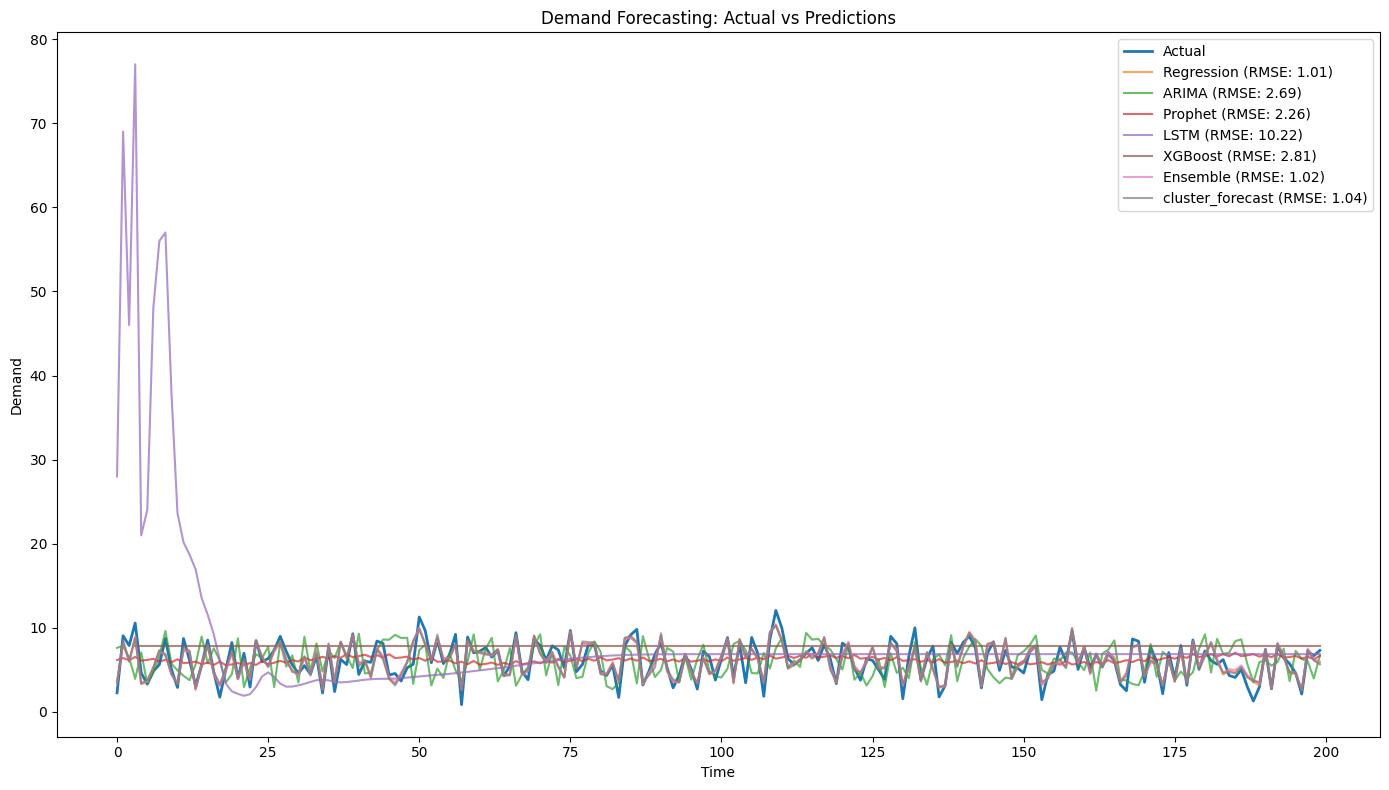

In [11]:
import os
import sys
import matplotlib.pyplot as plt
from data.data_generator import DataGenerator
from data.google_cluster_data import GoogleClusterData
from clustering.cluster_model import ClusterModel
from forecasting.regression_model import RegressionModel
from forecasting.arima_model import ARIMAModel
from forecasting.prophet_model import ProphetModel
from forecasting.lstm_model import LSTMModel
from forecasting.xgboost_model import XGBoostModel
from forecasting.ensemble_model import EnsembleModel
from forecasting.cluster_forecasting_model import ClusterForecastingModel
from utils.utils import calculate_rmse 
import warnings
warnings.filterwarnings('ignore')

# Add project root to sys.path if running from subfolders
if "__file__" in globals():
    sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
else:
    # Fallback for Jupyter Notebook
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    sys.path.append(project_root)
# ------------------------------
# Load data
# ------------------------------
source = "synthetic"  # or "google"

if source == "synthetic":
    data = DataGenerator(n_samples=1000).generate()
else:
    data = GoogleClusterData("data/google_cluster_sample.csv").load_and_preprocess()

data.rename(columns={'y': 'demand'}, inplace=True)
features = [col for col in data.columns if col != 'demand']

# ------------------------------
# Train/Test split
# ------------------------------
train_size = int(0.8 * len(data))
train = data.iloc[:train_size]
test = data.iloc[train_size:].reset_index(drop=True)

# ------------------------------
# Clustering step
# ------------------------------

cluster_model = ClusterModel(n_clusters=5)



# ------------------------------
# Initialize models
# ------------------------------
models = {
    "Regression": RegressionModel(),
    "ARIMA": ARIMAModel(),
    "Prophet": ProphetModel(),
    "LSTM": LSTMModel(epochs=5),
    "XGBoost": XGBoostModel(),
    "Ensemble": EnsembleModel([
        RegressionModel(), ProphetModel()
    ]),
    'cluster_forecast': ClusterForecastingModel(cluster_model,
                                                base_model_cls= RegressionModel(), n_clusters=5
                                                )
}

results = {}

# ------------------------------
# Fit and evaluate models
# ------------------------------
for name, model in models.items():
    print(f"\n--- Running model: {name} ---")
    try:
        model.fit(train, features, 'demand')
        preds = model.predict(test, features)
        rmse = calculate_rmse(test['demand'], preds)
        results[name] = {"predictions": preds, "rmse": rmse}
        print(f"{name} RMSE: {rmse:.4f}")
    except Exception as e:
        print(f"Error with {name}: {e}")

# ------------------------------
# Plotting
# ------------------------------
plt.figure(figsize=(14, 8))
plt.plot(test['demand'].values, label='Actual', linewidth=2)

for name, res in results.items():
    plt.plot(res["predictions"], label=f'{name} (RMSE: {res["rmse"]:.2f})', alpha=0.7)

plt.legend()
plt.title("Demand Forecasting: Actual vs Predictions")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.tight_layout()
plt.show()
